In [208]:
import numpy as np
import pandas as pd
import pandasql as ps
import pingouin as pg

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

# reading the data 

In [197]:
row_df = pd.read_excel('chen_shalev_labeld_row_data.xlsx')

In [209]:
df = row_df[:]  # object copy

# Isolating relevant columns - first and last entry dates

In [210]:
df_entry_dates = df[['תאריך כניסה ראשונית לתוכנית', 'תאריך השמה אחרונה','תאריך דיווח השמה אחרונה','label']]

In [211]:
# in all the rows with df['תאריך השמה אחרונה'] == None also df['תאריך דיווח השמה אחרונה']== None
df.loc[df['תאריך השמה אחרונה'].astype(str)=='NaT','תאריך דיווח השמה אחרונה'].unique()

array(['NaT'], dtype='datetime64[ns]')

## calculating the time differnec between first to last entry date

In [213]:
df_entry_dates.loc[:,'days_diff'] = df['תאריך השמה אחרונה'] - df_entry_dates['תאריך כניסה ראשונית לתוכנית']

## converting "delta time" column type to integer


In [214]:
df_entry_dates.loc[:,'days_diff'] = df_entry_dates['days_diff'].dt.days

# some statistics of days distribution

In [215]:
agg_data = ps.sqldf(f"""
                        SELECT  case when days_diff  = 0  then '0 days' 
                                     when days_diff  between 1   and 10  then 'between 1   and 10  days'
                                     when days_diff  between 11  and 30  then 'between 11  and 30  days'
                                     when days_diff  between 31  and 60  then 'between 31  and 60  days'
                                     when days_diff  between 61  and 100 then 'between 61  and 100 days'
                                     when days_diff  between 101 and 150 then 'between 101 and 150 days'
                                     when days_diff  between 151 and 200 then 'between 151 and 200 days'
                                     when days_diff  between 200 and 365 then 'between 200 and 365 days'
                                     when days_diff  >= 366              then 'bigger     then 365 days'
                                     end grouped_days_diff,
                                     count(*) absolut_number_of_people,
                                     cast(round(count(*)*1.0/(select count(*) from df_entry_dates)*100,3)  as varchar)  
                                     || '%' percenteg_of_people
                       FROM df_entry_dates 
                       group by 1
                       order by 2 asc
                       """, globals())

agg_data

,grouped_days_diff,absolut_number_of_people,percenteg_of_people
0,0 days,205,0.366%
1,between 1 and 10 days,1604,2.865%
2,between 151 and 200 days,1721,3.074%
3,between 101 and 150 days,2285,4.081%
4,between 61 and 100 days,2561,4.574%
5,between 11 and 30 days,2842,5.076%
6,between 31 and 60 days,3115,5.564%
7,between 200 and 365 days,4038,7.212%
8,bigger then 365 days,9625,17.191%
9,None,27993,49.997%


## extracting max,min,avg,median of days diff

In [216]:
df_entry_dates.describe()

,label,days_diff
count,55989.000000,39428.000000
mean,3.470735,-273.324541
std,0.890112,1435.187507
min,1.000000,-8007.000000
25%,3.000000,-27.000000
50%,4.000000,67.000000
75%,4.000000,354.000000
max,4.000000,2034.000000


###  - now is clearly shown that most of the people that were in the program have no 'תאריך השמה ' (50% of the people)


### - more then 0.25% of the people have negative diff, pointing on data issues ,  so now lets print description of the above but without the problematic samples

In [217]:
df_entry_dates[df_entry_dates['days_diff']>=0][['days_diff']].describe()

,days_diff
count,27996.000000
mean,341.418060
std,377.631689
min,0.000000
25%,52.000000
50%,189.000000
75%,514.000000
max,2034.000000


# scatter plot of days differences with control limits

### relevant columns isolation

In [220]:
df = df_entry_dates[df_entry_dates['days_diff']>=0][['days_diff','label']]
df['index'] = df.index

### Its easy to see that the following plot is not very meaningful

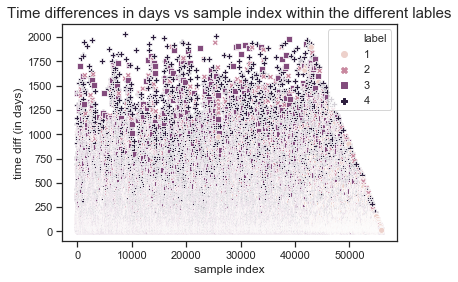

In [221]:
ax = plt.axes()
g = sns.scatterplot(x="index", y="days_diff",
                     hue="label", style="label", data=df)
g.set(xlabel='sample index', ylabel='time diff (in days)')
g.set_title("Time differences in days vs sample index within the different lables",size = 15)
plt.show()

###  since there is too many samples it very difficult to understand the days_diff distribution between the different labels
### so we want to take a look on each label separately and draw control limit of 3 standard deviation with respect to all the samples

##### --- calculating  standard deviation multiply by 3  --- 

In [222]:
sd = np.std(df['days_diff']) * 3

##### --- adding  nd substracting the  standard deviation multiply by 3  to the mean --- 

In [223]:
mean = np.mean(df['days_diff'])
lower_control_limit = mean - sd 
upper_control_limit = mean + sd 

# since the lower control limit is less then 0 not interest in its plot
lower_control_limit

-791.4567751367504

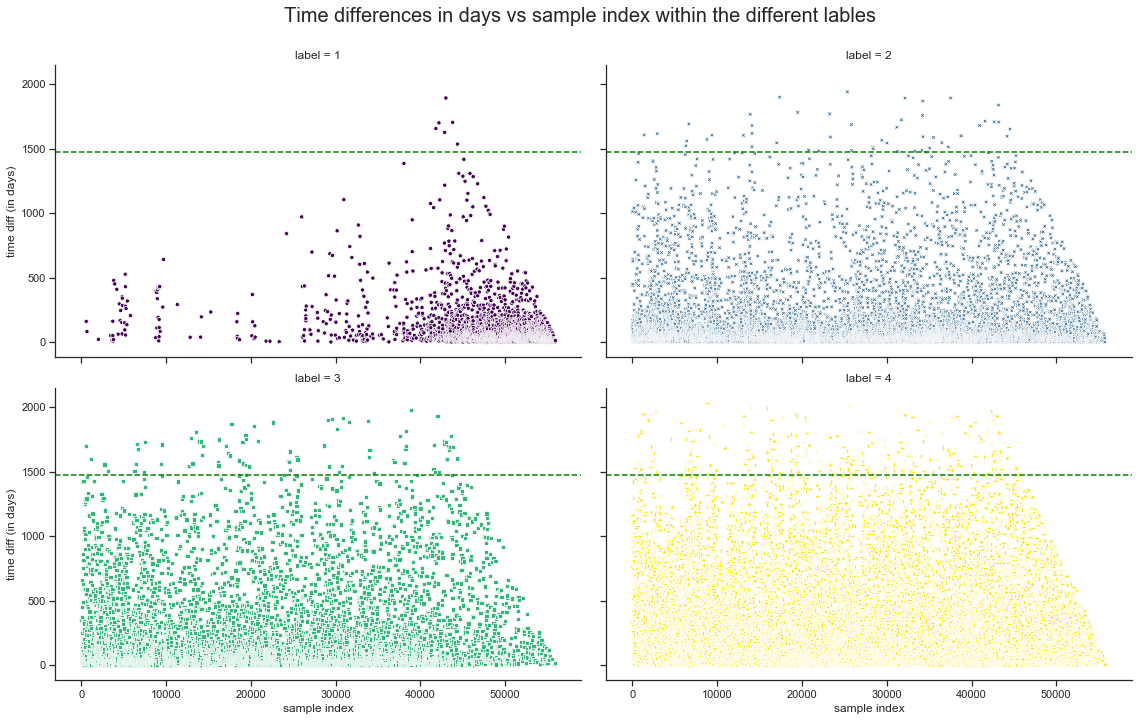

In [224]:
g = sns.relplot(x="index", y="days_diff",
                 col="label", hue="label", style="label",col_wrap=2,
                 kind="scatter", data=df, size=5, aspect=1.5,palette='viridis')

g.map(plt.axhline, y=upper_control_limit, ls='--', c='green')

g.fig.suptitle("Time differences in days vs sample index within the different lables",size = 20)
plt.subplots_adjust(top=0.90)
g.set(xlabel='sample index', ylabel='time diff (in days)')
g._legend.remove()


# let's check for difference between the days diff between the different labels by using ANOVA

In [225]:
aov = pg.anova(data=df, dv='days_diff', between='label', detailed=True)
print(aov)

   Source            SS     DF            MS        F p-unc  np2
0   label  4.003501e+08      3  1.334500e+08  1039.99     0  0.1
1  Within  3.591896e+09  27992  1.283187e+05        -     -    -


#### Its sgnificaly shown that there is different between the different labels groups 
#### In the following step we will use Tukey post hoc test to search for the source of the difference between all pairs combinations

In [226]:
pt = pg.pairwise_tukey(dv='days_diff', between='label', data=df)
print(pt)

   A  B  mean(A)  mean(B)     diff     se       tail       T  p-tukey  hedges
0  1  2  126.509  229.087 -102.577  8.574  two-sided -11.964    0.001  -0.286
1  1  3  126.509  298.207 -171.698  8.705  two-sided -19.723    0.001  -0.479
2  1  4  126.509  465.836 -339.326  8.087  two-sided -41.959    0.001  -0.947
3  2  3  229.087  298.207  -69.121  6.249  two-sided -11.061    0.001  -0.193
4  2  4  229.087  465.836 -236.749  5.354  two-sided -44.216    0.001  -0.661
5  3  4  298.207  465.836 -167.628  5.563  two-sided -30.133    0.001  -0.468


### We can say confidently that between all the pairs means exist difference such that the means decares with the decreas of the labels